In [1]:
!pip install gymnasium
!pip install gymnasium[classic-control]

Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F

import import_ipynb
from plastic_nn import plastic_nn
from plastic_nn import input_layer
from plastic_nn import layer

importing Jupyter notebook from plastic_nn.ipynb


In [2]:

# Define memory for Experience Replay
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)




class MountainCarDQL():
    # Hyperparameters (adjustable)
    
    discount_factor_g = 0.9         # discount rate (gamma)
    network_sync_rate = 50000          # number of steps the agent takes before syncing the policy and target network
    replay_memory_size = 100000       # size of replay memory
    mini_batch_size = 32            # size of the training data set sampled from the replay memory

    num_divisions = 20

    
    def plot_progress(self, rewards_per_episode, epsilon_history):
        plt.figure(1)
        plt.subplot(121) 
        plt.plot(rewards_per_episode)
        plt.subplot(122) # plot on a 1 row x 2 col grid, at cell 2
        plt.plot(epsilon_history)
        plt.savefig('mountaincar_dql.png')

    

    def train(self, policy_dqn, target_dqn, episodes, render=False):
        # Create FrozenLake instance
        env = gym.make('MountainCar-v0', render_mode='human' if render else None)
        num_states = env.observation_space.shape[0] # expecting 2: position & velocity
        num_actions = env.action_space.n

        # Divide position and velocity into segments
        self.pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], self.num_divisions)    # Between -1.2 and 0.6
        self.vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], self.num_divisions)    # Between -0.07 and 0.07

        epsilon = 1 # 1 = 100% random actions
        memory = ReplayMemory(self.replay_memory_size)

        rewards_per_episode = []
        epsilon_history = []

        # Track number of steps taken. Used for syncing policy => target network.
        step_count = 0
        goal_reached = False
        best_rewards = -200

        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False
            rewards = 0

            # Agent navigates map until it falls into hole/reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and rewards > -1000):
                if random.random() < epsilon:
                    action = env.action_space.sample() # actions: 0=left,1=idle,2=right
                else:
                    res = policy_dqn.forward(self.state_to_dqn_input(state))
                    #print(res)
                    action = res.argmax().item()

                new_state,reward,terminated,truncated,_ = env.step(action)
                rewards += reward
                memory.append((state, action, new_state, reward, terminated))
                state = new_state
                step_count+=1


            rewards_per_episode.append(rewards)
            epsilon_history.append(epsilon)
            
            if(terminated):
                goal_reached = True

            # Graph training progress
            if(i!=0 and i%1000==0):
                print(f'Episode {i} Epsilon {epsilon}')

                self.plot_progress(rewards_per_episode, epsilon_history)

            if rewards>best_rewards:
                best_rewards = rewards
                print(f'Best rewards so far: {best_rewards}')
                # Save policy
                #torch.save(policy_dqn.state_dict(), f"mountaincar_dql_{i}.pt")

            # Check if enough experience has been collected
            if len(memory)>self.mini_batch_size and goal_reached:
                #print(f'Episode {i} Epsilon {epsilon} rewards {rewards}') # print(rewards)
                mini_batch = memory.sample(self.mini_batch_size) #len(memory))#
                self.optimize(mini_batch, policy_dqn, target_dqn)

                # Decay epsilon
                #epsilon = max(epsilon*0.99999, 0.05)#epsilon = max(epsilon - 1/episodes, 0)
                epsilon = max(epsilon - 1/episodes, 0)
                epsilon_history.append(epsilon)

                # Copy policy network to target network after a certain number of steps
                if step_count > self.network_sync_rate:
                    # print("BEFORE COPY")
                    # policy_dqn.print_info()
                    # target_dqn.print_info()
                    
                    target_dqn = policy_dqn.deep_copy()
                    
                    # print("AFTER COPY")
                    # policy_dqn.print_info()
                    # target_dqn.print_info()
                    
                    step_count = 0

        env.close()



    
    def optimize(self, mini_batch, policy_dqn, target_dqn):

        current_q_list = []
        target_q_list = []
        #print('before! ')
        #self.test(policy_dqn, 1)
        
        for state, action, new_state, reward, terminated in mini_batch:

            if terminated:
                target = reward
            else:
                target = reward + self.discount_factor_g * target_dqn.forward(self.state_to_dqn_input(new_state)).max()


            # Get the target set of Q values
            target_q = target_dqn.forward_nu(self.state_to_dqn_input(state))
            
            # Get the current set of Q values
            current_q = policy_dqn.forward(self.state_to_dqn_input(state))
            current_q_list.append(current_q)
            
            # Adjust the specific action to the target that was just calculated
            target_q[action] = target
            target_q_list.append(target_q)

    
            #BACKPOP AND UPDATE
            #err =  target_q - current_q
            #policy_dqn.backprop_error(err)
            #print('backprop\n')
            policy_dqn.backprop(target_q)
            policy_dqn.update_w()

            #print('\nupdate! ')
            #self.test(policy_dqn, 1)
        
        # Compute loss for the whole minibatch ??
    
        #loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimize the model
        #self.optimizer.zero_grad()
        #loss.backward()
        #self.optimizer.step()


    def state_to_dqn_input(self, state):
        state_p = np.digitize(state[0], self.pos_space)
        state_v = np.digitize(state[1], self.vel_space)

        return [state_p, state_v]

    # Run the environment with the learned policy
    def test(self, policy_dqn, episodes):
        # Create FrozenLake instance
        env = gym.make('MountainCar-v0', render_mode='human')
        num_states = env.observation_space.shape[0]
        num_actions = env.action_space.n

        self.pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], self.num_divisions)    # Between -1.2 and 0.6
        self.vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], self.num_divisions)    # Between -0.07 and 0.07

        # Load learned policy
        #policy_dqn = DQN(in_states=num_states, h1_nodes=10, out_actions=num_actions)
        #policy_dqn.load_state_dict(torch.load(model_filepath))
        #policy_dqn.eval()    # switch model to evaluation mode

        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False       # True when agent takes more than 200 actions

            # Agent navigates map until it falls into a hole (terminated), reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and not truncated):
                dscr = self.state_to_dqn_input(state)
                res = policy_dqn.forward_print(dscr)
                print(res)
                action = res.argmax().item()

                # Execute action
                state,reward,terminated,truncated,_ = env.step(action)
                #terminated = True

        env.close()


In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F

import import_ipynb
from plastic_nn import plastic_nn
from plastic_nn import input_layer
from plastic_nn import layer

learning_rate_a = 0.01
in_states = 2
h1_nodes = 10
h2_nodes = 10
out_actions = 3

layers_net = [input_layer(in_states), 
layer(lr = learning_rate_a, prev_size = in_states, my_size=h1_nodes, activation_type="ReLU"), 
#layer(lr = learning_rate_a, prev_size = h1_nodes, my_size=h2_nodes, activation_type="ReLU"), 
layer(lr = learning_rate_a, prev_size = h2_nodes, my_size=out_actions, activation_type='Linear')] #, activation_type="ReLU")]

policy_dqn = plastic_nn()
policy_dqn.append(layers_net)

target_dqn = plastic_nn()
target_dqn = policy_dqn.deep_copy()
        
# env = gym.make('MountainCar-v0') #, render_mode='human' if render else None)
# state, _ = env.reset()

# pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 20)    # Between -1.2 and 0.6
# vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 20)    # Between -0.07 and 0.07
# state_p = np.digitize(state[0], pos_space)
# state_v = np.digitize(state[1], vel_space)
# state=[state_p, state_v]

# print(policy_dqn.forward(state))
# env.close()
target_dqn.save('test.txt')
target_dqn.load('test.txt')

importing Jupyter notebook from plastic_nn.ipynb
added LAYERS succesfully
5.079241420750183478e-01 5.573443377993552161e-01 7.387738744437428728e-01

8.968773391479627488e-01 7.797960523553748580e-01 4.482744352924272757e-01

2.278911417023504749e-01 3.159274381969602308e-01 8.194891702461690741e-01

7.705564768191237590e-01 4.291787088726602972e-01 2.225660741427004652e-02

7.930025594365948116e-01 2.392073182582546975e-01 7.778848987334169296e-01

2.515781995212732491e-01 2.628607017730089090e-01 9.239065400231927239e-01

4.818761687581418762e-02 7.568701988151518290e-01 8.370038036135494242e-01

6.115253416695032307e-02 1.557834034695169123e-01 1.028583477283975256e-01

2.910915550507559013e-01 6.408809259150959337e-01 3.218426213993802465e-01

6.363182911138709485e-01 1.805917536760925923e-01 3.748208829821257915e-01







In [18]:
mountaincar = MountainCarDQL()

Episode 1000 Epsilon 0.9781199999999781
Episode 2000 Epsilon 0.9381199999999381
Episode 3000 Epsilon 0.8981199999998981
Episode 4000 Epsilon 0.8581199999998581
Episode 5000 Epsilon 0.8181199999998181
Episode 6000 Epsilon 0.7781199999997781
Episode 7000 Epsilon 0.7381199999997381
Episode 8000 Epsilon 0.6981199999996981
Episode 9000 Epsilon 0.6581199999996581
Episode 10000 Epsilon 0.6181199999996181
Episode 11000 Epsilon 0.5781199999995781
Episode 12000 Epsilon 0.5381199999995381
Episode 13000 Epsilon 0.49811999999950074
Episode 14000 Epsilon 0.45811999999951625
Episode 15000 Epsilon 0.41811999999953176
Episode 16000 Epsilon 0.37811999999954726
Episode 17000 Epsilon 0.33811999999956277
Episode 18000 Epsilon 0.2981199999995783
Episode 19000 Epsilon 0.2581199999995938
Episode 20000 Epsilon 0.21811999999958714
Episode 21000 Epsilon 0.1781199999995749
Episode 22000 Epsilon 0.13811999999956265
Episode 23000 Epsilon 0.09811999999955974
Episode 24000 Epsilon 0.05811999999956137


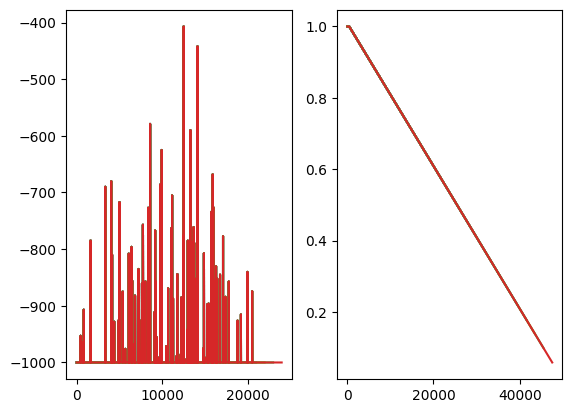

In [15]:
mountaincar.train(policy_dqn, target_dqn, 25000, False)

In [19]:
mountaincar.test(policy_dqn, 1)

in:  [8, 10]
0   [8, 10]
1   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2   [-0.48869229 -0.36595754 -0.50305646]
[-0.48869229 -0.36595754 -0.50305646]
in:  [8, 10]
0   [8, 10]
1   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2   [-0.48869229 -0.36595754 -0.50305646]
[-0.48869229 -0.36595754 -0.50305646]
in:  [8, 10]
0   [8, 10]
1   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2   [-0.48869229 -0.36595754 -0.50305646]
[-0.48869229 -0.36595754 -0.50305646]
in:  [8, 10]
0   [8, 10]
1   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2   [-0.48869229 -0.36595754 -0.50305646]
[-0.48869229 -0.36595754 -0.50305646]
in:  [8, 10]
0   [8, 10]
1   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2   [-0.48869229 -0.36595754 -0.50305646]
[-0.48869229 -0.36595754 -0.50305646]
in:  [8, 10]
0   [8, 10]
1   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2   [-0.48869229 -0.36595754 -0.50305646]
[-0.48869229 -0.36595754 -0.50305646]
in:  [8, 10]
0   [8, 10]
1   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2   [-0.48869229 -0.36595754 -0.50305646]
[-0.48869229 -0.36595754 -0.50305646]
in:  [8, 10]


In [20]:
policy_dqn.print_info()

NAME:  noname  ( 3 )
# 0
IN LAYER
size:  2
[0. 0.]

# 1
my size:  10
w:  [[-8.49227418e+00 -2.47342115e-01  7.31658288e-03 -3.15628302e+01
   1.01490522e-01 -3.96523062e+01 -2.44588631e+01  9.63111330e-02
  -4.42328672e+01 -4.85793094e-01]
 [-1.26065081e+01 -7.13498499e-01 -2.39011552e-01 -3.02919275e+01
  -6.55944168e-01 -3.84010635e+01 -2.46607815e+01 -5.74069550e-01
  -4.16206430e+01 -2.53774952e+00]] 

b:  [-0.86369555  0.77725613  0.25138123 -3.42197561  0.36459762 -4.4134715
 -1.34685652  0.26454359 -4.39066117 -0.12404163] 


# 2
my size:  3
w:  [[ 0.2863429   0.39240644  0.38172158]
 [ 0.96349238  0.64075146  0.08161278]
 [ 0.13923009  0.83272756  0.52563895]
 [-1.45600962 -1.25350803 -1.3547194 ]
 [ 0.17639425  0.7748954   0.64992655]
 [-1.03913422 -1.34285395 -1.0620498 ]
 [-0.05219997  0.21913309  0.22869735]
 [ 0.20508629  0.76872685  0.26903104]
 [-1.07739075 -0.92890501 -1.11630672]
 [-0.04408081 -0.18077988  0.47936032]] 

b:  [-0.48869229 -0.36595754 -0.50305646] 


